In [1]:
import json
import pandas as pd
import numpy as np
import os
import sys
import tensorflow as tf
from time import time
import io
import re

import pickle
from csv import reader
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from tensorflow.keras import layers
from tensorflow.keras.backend import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import plot_model

# physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

from datetime import datetime
from collections import defaultdict

from sklearn.model_selection import train_test_split



In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [15]:
from transformers import TFXLNetForSequenceClassification, XLNetTokenizer

## Data

In [4]:
test_dataset = pd.read_table("sourcelevel_test_dataset.csv",  index_col=0)
test_dataset = test_dataset[:8000]
test_dataset

,topic,source,bias,url,title,date,authors,content,content_original,source_url,bias_text,ID,pred_labels
0,palestine,Breitbart News,2,http://www.breitbart.com/big-journalism/2015/0...,"Obama, Media Lied About Netanyahu and the Pale...",2015-03-20,Ben Shapiro,"For the last several days , the entire Western...","For the last several days, the entire Western ...",www.breitbart.com,right,uI2K5BSCO0LaWuKb,2
1,federal_budget,ABC News,0,http://abcnews.go.com/blogs/politics/2013/03/w...,Will Fractured House Republicans Unite on Budget?,NaN,John Parkinson,"Tomorrow morning , House Budget Chairman Paul ...","Jacquelyn Martin/AP Photo\n\nTomorrow morning,...",www.abcnews.go.com,left,zeSfcxLilzR0R1Dt,0
2,fbi,Reuters,1,https://www.reuters.com/article/us-usa-trump-r...,Trump blocks release of Russia memo drafted by...,2018-02-10,Ayesha Rascoe,WASHINGTON ( ███ ) - President Donald Trump on...,WASHINGTON (Reuters) - President Donald Trump ...,www.reuters.com,center,ru8kAxfdPzZc11le,0
3,politics,CBN,2,http://www1.cbn.com/cbnnews/politics/2019/febr...,Trump's North Korea Peace Talks Share Spotligh...,2019-02-25,NaN,"President Donald Trump arrives in Hanoi , Viet...","President Donald Trump arrives in Hanoi, Vietn...",www1.cbn.com,right,TTt5FFmsW6ng3fsC,0
4,media_bias,Breitbart News,2,http://www.breitbart.com/big-government/2017/0...,Six Times President Trump Upset Jared Kushner ...,2017-08-20,Adam Shaw,President Trump ’ s fiery response to the even...,President Trump’s fiery response to the events...,www.breitbart.com,right,gYKaZGjLCYdEghTZ,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,politics,CBN,2,http://www1.cbn.com/cbnnews/politics/2018/augu...,America 'Was Never that Great': NY Gov. Andrew...,2018-08-16,NaN,New York Gov . Andrew Cuomo surprised an audie...,New York Gov. Andrew Cuomo surprised an audien...,www1.cbn.com,right,tx0ljfh22jS6RtHp,2
1296,fbi,Salon,0,http://www.salon.com/2017/05/10/the-fbi-is-ree...,The FBI is reeling from shock of Comey’s unexp...,2017-05-10,Matthew Rozsa,Agents who work for the FBI are reported to be...,Agents who work for the FBI are reported to be...,www.salon.com,left,HFWrdvZbzVjgJU81,1
1297,politics,Newsmax,2,http://www.newsmax.com/Newsfront/loretta-lynch...,Human-Trafficking Bill Fight Could Hold Up Lor...,2015-03-15,NaN,The U.S. Senate majority leader said Sunday he...,The U.S. Senate majority leader said Sunday he...,www.newsmax.com,right,EpeNKrMWiScat2Hm,0
1298,media_bias,The Daily Caller,2,http://dailycaller.com/2016/11/30/fake-news-me...,Fake News: Media Pushes Bogus Survey As Proof ...,2016-11-30,NaN,Multiple U.S. media outlets are citing an onli...,Multiple U.S. media outlets are citing an onli...,www.dailycaller.com,right,o2fN4uERGL363uh0,1


In [5]:

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
# tokenizer_transformer = XLNetTokenizer.from_pretrained('xlnet-large-cased')
test_labels = np.asarray(le.fit_transform(test_dataset['bias_text']))

test_dataset["real_labels"] =test_labels
test_dataset

,topic,source,bias,url,title,date,authors,content,content_original,source_url,bias_text,ID,pred_labels,real_labels
0,palestine,Breitbart News,2,http://www.breitbart.com/big-journalism/2015/0...,"Obama, Media Lied About Netanyahu and the Pale...",2015-03-20,Ben Shapiro,"For the last several days , the entire Western...","For the last several days, the entire Western ...",www.breitbart.com,right,uI2K5BSCO0LaWuKb,2,2
1,federal_budget,ABC News,0,http://abcnews.go.com/blogs/politics/2013/03/w...,Will Fractured House Republicans Unite on Budget?,NaN,John Parkinson,"Tomorrow morning , House Budget Chairman Paul ...","Jacquelyn Martin/AP Photo\n\nTomorrow morning,...",www.abcnews.go.com,left,zeSfcxLilzR0R1Dt,0,1
2,fbi,Reuters,1,https://www.reuters.com/article/us-usa-trump-r...,Trump blocks release of Russia memo drafted by...,2018-02-10,Ayesha Rascoe,WASHINGTON ( ███ ) - President Donald Trump on...,WASHINGTON (Reuters) - President Donald Trump ...,www.reuters.com,center,ru8kAxfdPzZc11le,0,0
3,politics,CBN,2,http://www1.cbn.com/cbnnews/politics/2019/febr...,Trump's North Korea Peace Talks Share Spotligh...,2019-02-25,NaN,"President Donald Trump arrives in Hanoi , Viet...","President Donald Trump arrives in Hanoi, Vietn...",www1.cbn.com,right,TTt5FFmsW6ng3fsC,0,2
4,media_bias,Breitbart News,2,http://www.breitbart.com/big-government/2017/0...,Six Times President Trump Upset Jared Kushner ...,2017-08-20,Adam Shaw,President Trump ’ s fiery response to the even...,President Trump’s fiery response to the events...,www.breitbart.com,right,gYKaZGjLCYdEghTZ,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,politics,CBN,2,http://www1.cbn.com/cbnnews/politics/2018/augu...,America 'Was Never that Great': NY Gov. Andrew...,2018-08-16,NaN,New York Gov . Andrew Cuomo surprised an audie...,New York Gov. Andrew Cuomo surprised an audien...,www1.cbn.com,right,tx0ljfh22jS6RtHp,2,2
1296,fbi,Salon,0,http://www.salon.com/2017/05/10/the-fbi-is-ree...,The FBI is reeling from shock of Comey’s unexp...,2017-05-10,Matthew Rozsa,Agents who work for the FBI are reported to be...,Agents who work for the FBI are reported to be...,www.salon.com,left,HFWrdvZbzVjgJU81,1,1
1297,politics,Newsmax,2,http://www.newsmax.com/Newsfront/loretta-lynch...,Human-Trafficking Bill Fight Could Hold Up Lor...,2015-03-15,NaN,The U.S. Senate majority leader said Sunday he...,The U.S. Senate majority leader said Sunday he...,www.newsmax.com,right,EpeNKrMWiScat2Hm,0,2
1298,media_bias,The Daily Caller,2,http://dailycaller.com/2016/11/30/fake-news-me...,Fake News: Media Pushes Bogus Survey As Proof ...,2016-11-30,NaN,Multiple U.S. media outlets are citing an onli...,Multiple U.S. media outlets are citing an onli...,www.dailycaller.com,right,o2fN4uERGL363uh0,1,2


In [ ]:
# 0 is center
# 1 is left
# 2 is right

<AxesSubplot:>

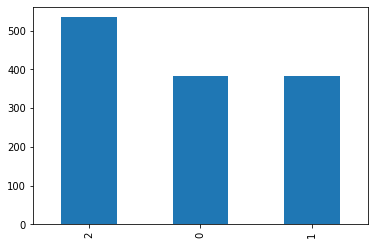

In [6]:
test_dataset["pred_labels"].value_counts().plot.bar()

<AxesSubplot:>

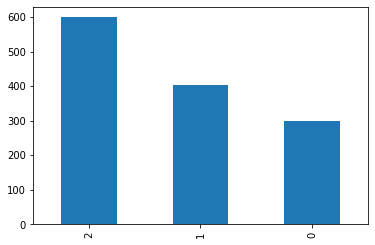

In [7]:
test_dataset["real_labels"].value_counts().plot.bar()

<AxesSubplot:>

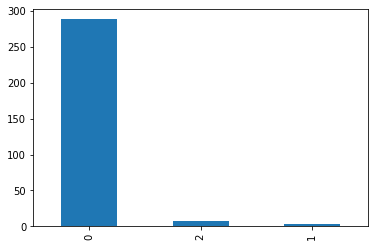

In [8]:
test_dataset[test_dataset["real_labels"]==0]["pred_labels"].value_counts().plot.bar()

<AxesSubplot:>

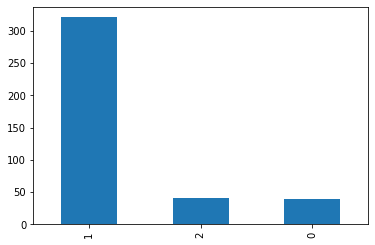

In [9]:
test_dataset[test_dataset["real_labels"]==1]["pred_labels"].value_counts().plot.bar()

<AxesSubplot:>

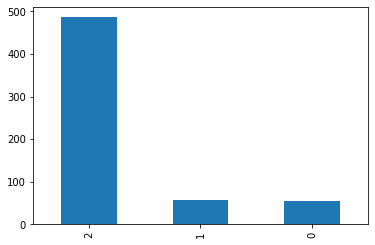

In [10]:
test_dataset[test_dataset["real_labels"]==2]["pred_labels"].value_counts().plot.bar()

In [12]:
from sklearn.metrics import accuracy_score

accuracy_score(test_dataset["real_labels"], test_dataset["pred_labels"])

0.8423076923076923